# Predicting seasonal words

In this notebook we show the use of our previous seasonal arima model for predicting words that have a strong seasonal component. The goal is to see if the model can correctly fit and interpret this seasonality and if it can more accurately predict the frequency than for word that are less regular.

The word need to have a strong seasonal component wich means they should show an strong increase of decrease at regular period.

We spotted a few word that have this sort of regularity for obvious reasons. Here after we are going to focus on two words: "neiger" and the word "noële".

"neiger" regroup some other word linked to the snow after the preprocessing.

"noële" is written like that due to the preprocessing.

Both show strong increase at a precise period. Winter for "neiger" and the period before christmas for "noële"

Import the necessary libraries

In [82]:
import os, glob, string, re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
%matplotlib inline

In [83]:
# For plotting nicely

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return  (x*100)
csfont = {'fontname':'Arial'}
hfont = {'fontname':'Arial'}
formatter = FuncFormatter(millions)
sns.set_style("whitegrid",{'grid.color': '0.95','grid.linewidth': 0.01})
sns.set_context("poster")

mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['figure.autolayout'] =  True



Downloading the data from the previous cleaning part

In [4]:
wordCountYear = pd.read_csv('3kplusWordMonth.csv',index_col=0)
wordCountYear.head()

,-a,-la,-le,-on,-—,aarau,aarberg,aarbourg,aarcorp,aarg,...,œcuménique,œcuménisme,œdipe,œil,œillet,œquo,œrlikon,œuf,œur-,œuvre
1806-05-01,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-07-01,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-09-01,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


Grouping to join the two newspaper

In [5]:
wordCountYear = wordCountYear.groupby(wordCountYear.index, level=0).agg(sum)

Transforming the absolute occurence of every words into frequencies

In [6]:
wordCountYear.index = pd.to_datetime(wordCountYear.index)
yearIndex = wordCountYear.index
#normalization
wordNorm = wordCountYear.divide(wordCountYear.sum(axis=1).values,axis=0)

Here we show the visualization of the word "noële" that we are going to predict later.

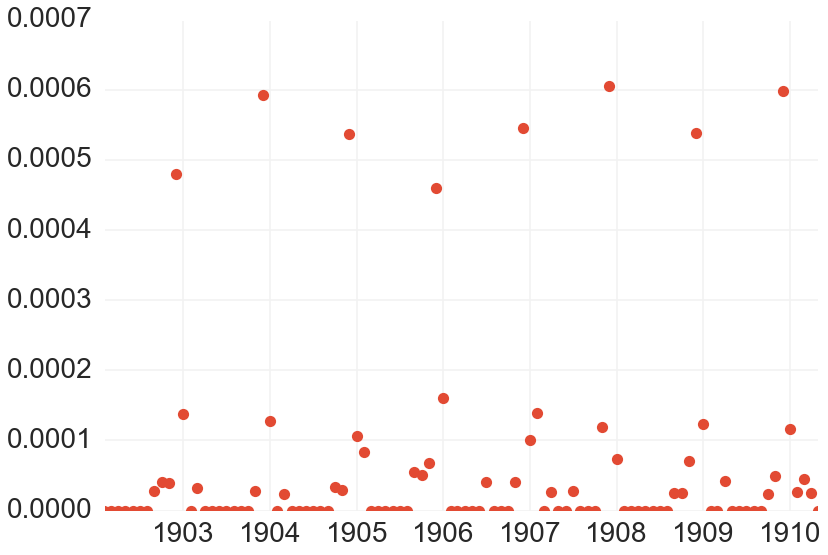

In [9]:
plt.plot_date(yearIndex[1200:1300],wordNorm['noële'].values[1200:1300])
plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)



Here we show the visualization of the word "neiger" that we are going to predict later.

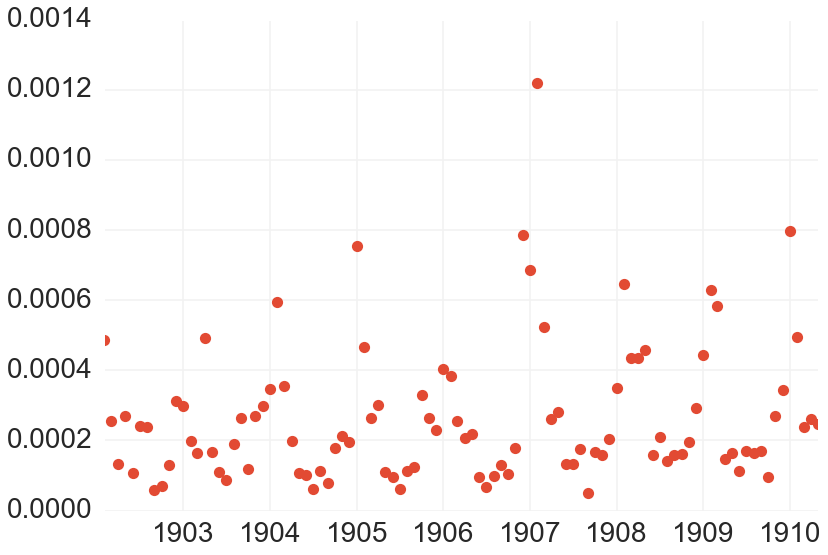

In [10]:
plt.plot_date(yearIndex[1200:1300],wordNorm['neiger'].values[1200:1300])
plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

We select this time serie for the word "noële" and the word "neiger" and we reshape it in array form that suit the following of our processing

In [11]:
time_serie_neiger = wordNorm['neiger']
time_serie_noele = wordNorm['noële']

Here we make a copy of the time serie and we replace all the 0 value by NaN. This is required for the interpolation that we will apply soon after in order to remove the 0 values.

In [12]:
serie_nan_neiger = time_serie_neiger.copy()
serie_nan_noele = time_serie_noele.copy()

In [13]:
serie_nan_neiger[serie_nan_neiger == 0] = np.nan
serie_nan_noele[serie_nan_noele == 0] = np.nan

Now we apply interpolation. We assume that the non occurence of a words during a month while it was present before and after this month can be considered to be a kind of error due to the inherent essence of newspaper where words can be eclispsed by other due to important event even though the trend is that the word is used.

In [14]:
serie_inter_neiger = serie_nan_neiger.interpolate()
serie_inter_noele = serie_nan_noele.interpolate()

And we rechange back the NaN value that have not been interpolated (if not beetween real values).

In [15]:
serie_final_neiger = serie_inter_neiger.fillna(0)
serie_final_noele = serie_inter_noele.fillna(0)

We can see the results for the two words

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


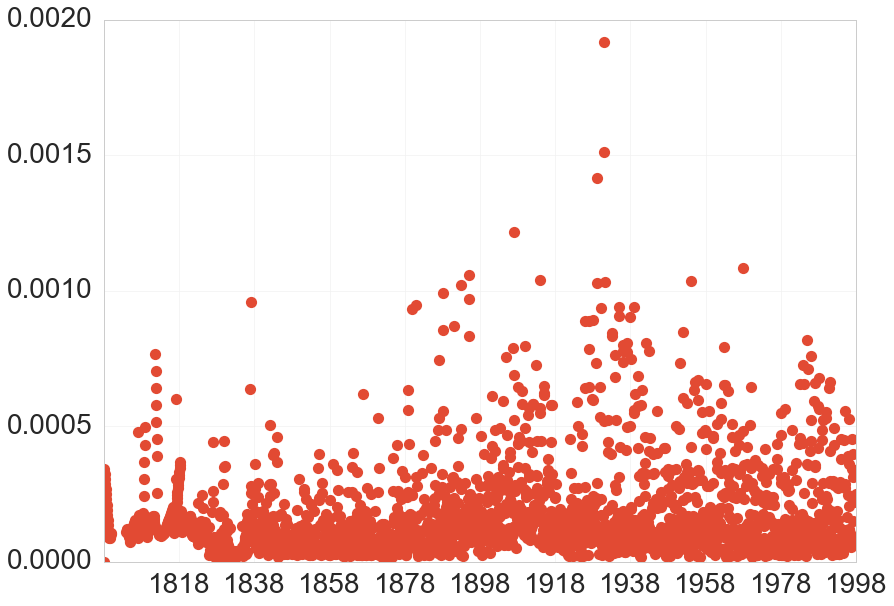

In [84]:
plt.plot_date(yearIndex,serie_final_neiger)
plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


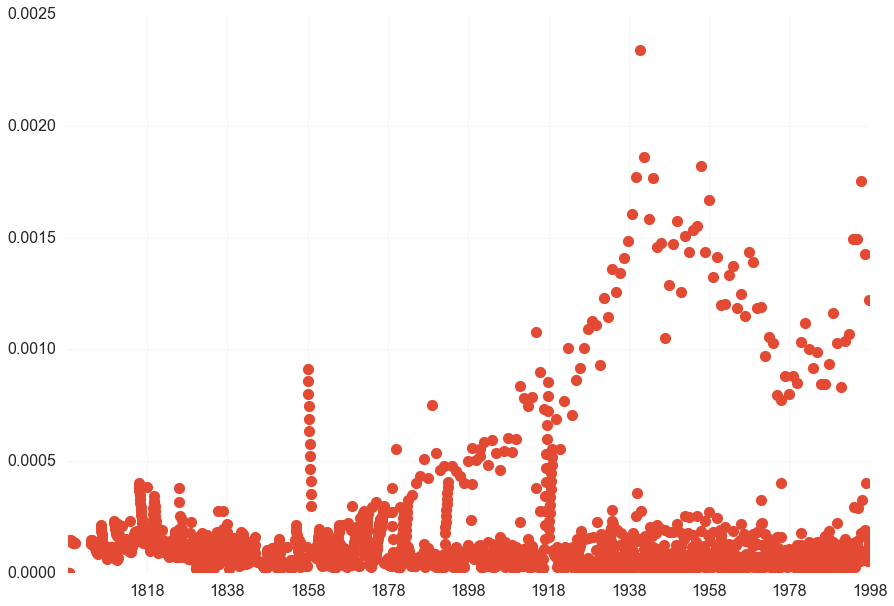

In [85]:
plt.plot_date(yearIndex,serie_final_noele)

# Time serie prediction


Now we will apply the same seasonal model as used before on these two words. Check if we can find better parameters for better results.

As before we process a rolling mean on the time series and this is that rolling means data that we are going to try to predict.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=16).mean()
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


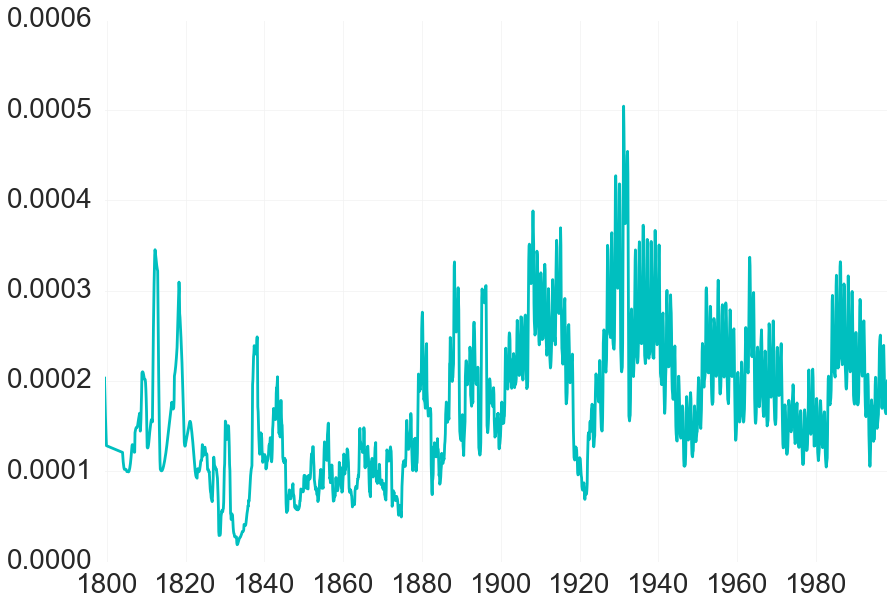

In [86]:
rolmean_neiger = pd.rolling_mean(serie_final_neiger, window=16)
rolmean_neiger.dropna(inplace=True) #This is needed to remove the nan that appears at the beginning and the end
plt.plot(rolmean_neiger, c='c')
plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)



//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=16).mean()
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


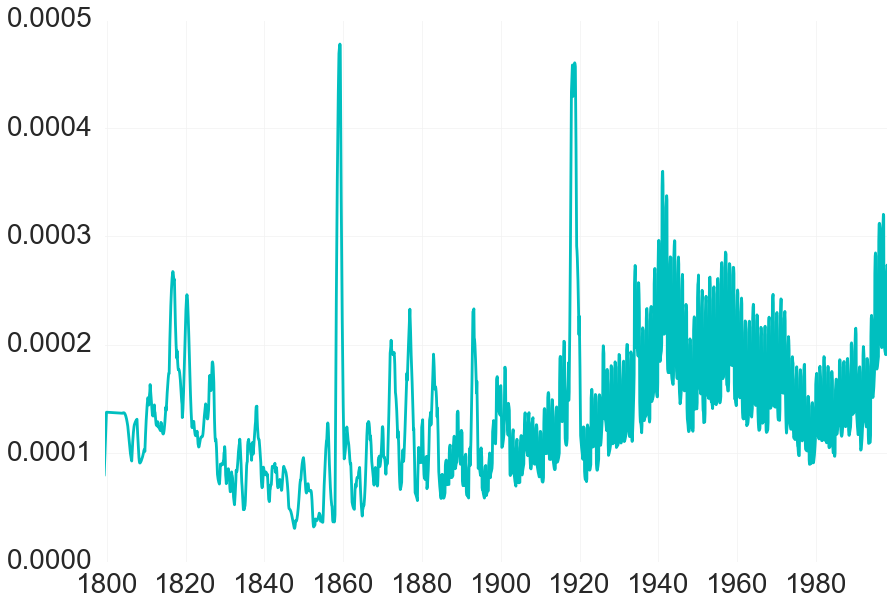

In [87]:
rolmean_noele = pd.rolling_mean(serie_final_noele, window=16)
rolmean_noele.dropna(inplace=True) #This is needed to remove the nan that appears at the beginning and the end
plt.plot(rolmean_noele, c='c')
plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

We gonna cut apart of the data in order to keep the last 3 years as unseen data for testing (out of sample forecast)

In [88]:
# We cut the time serie 36 months

rolmean_neiger_train = rolmean_neiger[:2300].copy()
rolmean_noele_train = rolmean_noele[:2300].copy()

As before we make the two serie stationary by the use of differentiation


In [89]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

Below is the definition of a function for testing the stationarity of a time serie. Of course we already know from previous visualization that the serie is not stationary but we want to make a better visualization of it as well as a statistical test. We use the Dickey-fuller test for stationarity

In [141]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=48)
    rolstd = pd.rolling_std(timeseries, window=48)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='c',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.rc('axes',edgecolor='white')
    plt.tick_params(axis='both', which='major', labelsize=28)
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

We test our time serie (the rolling mean) only for the word neiger

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=48).mean()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=48).std()
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


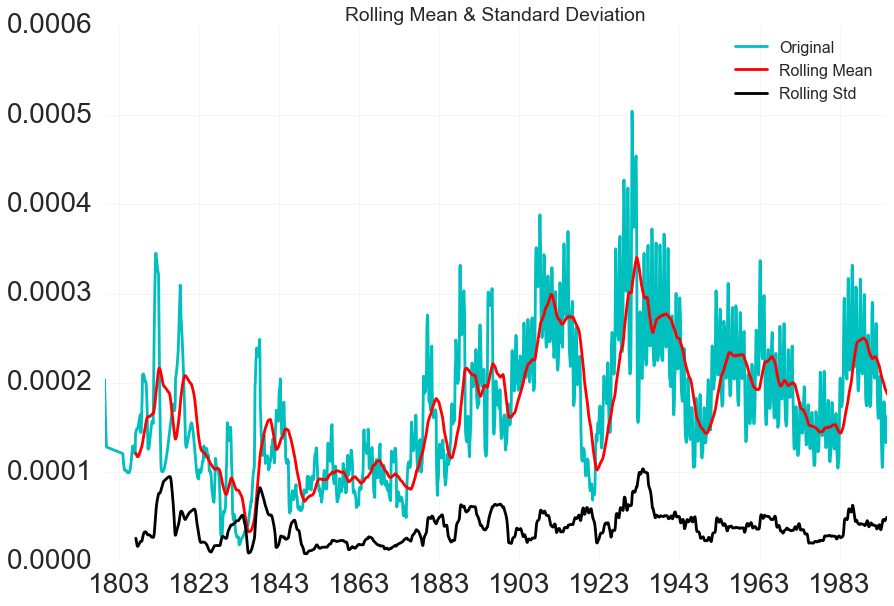

Results of Dickey-Fuller Test:
Test Statistic                   -3.955608
p-value                           0.001662
#Lags Used                       24.000000
Number of Observations Used    2275.000000
Critical Value (1%)              -3.433228
Critical Value (10%)             -2.567447
Critical Value (5%)              -2.862811
dtype: float64


In [142]:
test_stationarity(rolmean_neiger_train)

Surprisingly the test show that the serie is stationnary for a 10% and 5% critical value (as seen by the test statistic value which is bigger than those value in absolute value). This may be due to the fact that the serie appears to have a trend but if we look with more granularity the serie appears flat. The change in mean would thus be very slow and not detected. 

Still we will try to increase stationnarity by substracting a shifted value or the serie to itself.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=48).mean()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=48).std()
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


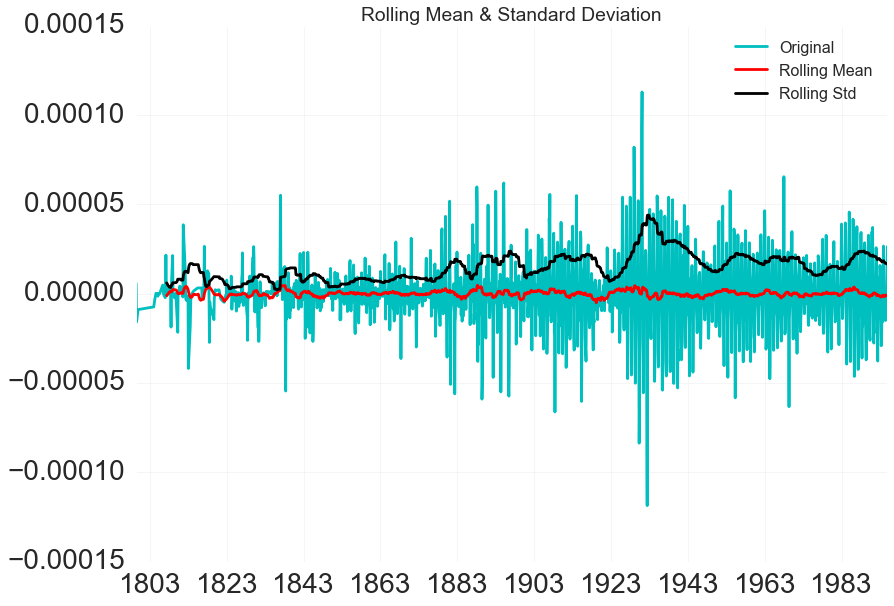

Results of Dickey-Fuller Test:
Test Statistic                -1.053397e+01
p-value                        9.000539e-19
#Lags Used                     2.300000e+01
Number of Observations Used    2.275000e+03
Critical Value (1%)           -3.433228e+00
Critical Value (10%)          -2.567447e+00
Critical Value (5%)           -2.862811e+00
dtype: float64


In [143]:
first_difference_neiger = rolmean_neiger_train - rolmean_neiger_train.shift(1)
first_difference_neiger.dropna(inplace=True)
test_stationarity(first_difference_neiger)

In [144]:
first_difference_noele = rolmean_noele_train - rolmean_noele_train.shift(1)
first_difference_noele.dropna(inplace=True)

We can see that we increased the stationnarity (the test statistic value is bigger in absolute value) now it is even bigger than the 1% critical value.

In order to increase again the stationnarity and take into accound the seasonality of our serie, we substract the first difference that we just computed with a shifted version of itself by 12 month. 

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=48).mean()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=48).std()
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


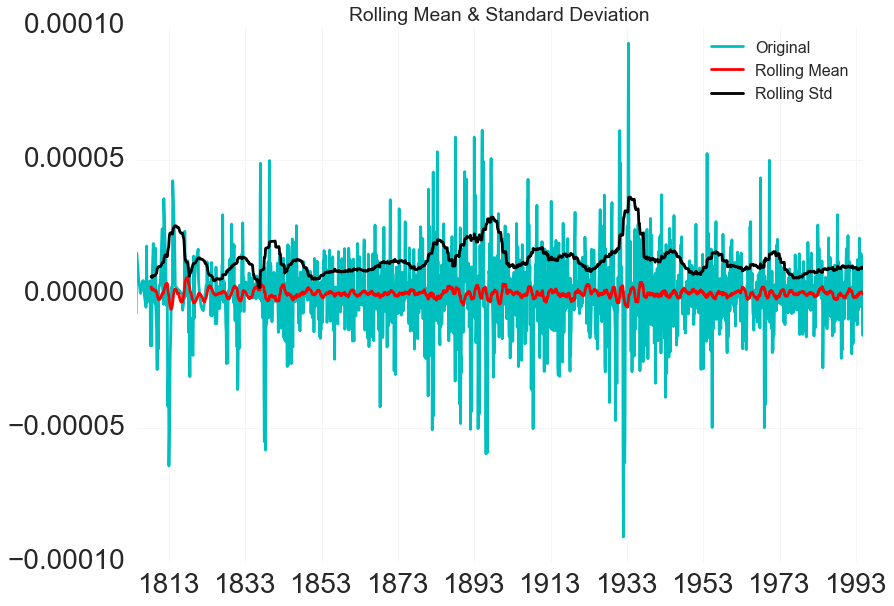

Results of Dickey-Fuller Test:
Test Statistic                -1.703146e+01
p-value                        8.319447e-30
#Lags Used                     2.700000e+01
Number of Observations Used    2.259000e+03
Critical Value (1%)           -3.433248e+00
Critical Value (10%)          -2.567452e+00
Critical Value (5%)           -2.862820e+00
dtype: float64


In [145]:
seasonal_difference_neiger = first_difference_neiger - first_difference_neiger.shift(12)
seasonal_difference_neiger.dropna(inplace=True)

seasonal_difference_noele = first_difference_noele - first_difference_noele.shift(12)
seasonal_difference_noele.dropna(inplace=True)


test_stationarity(seasonal_difference_neiger)

Now the serie is stationary.


Now we can plot the autocorrelation and the partial autocorrelation. These two plots can tell us how to fine tune the parameters of our SARIMA model.

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


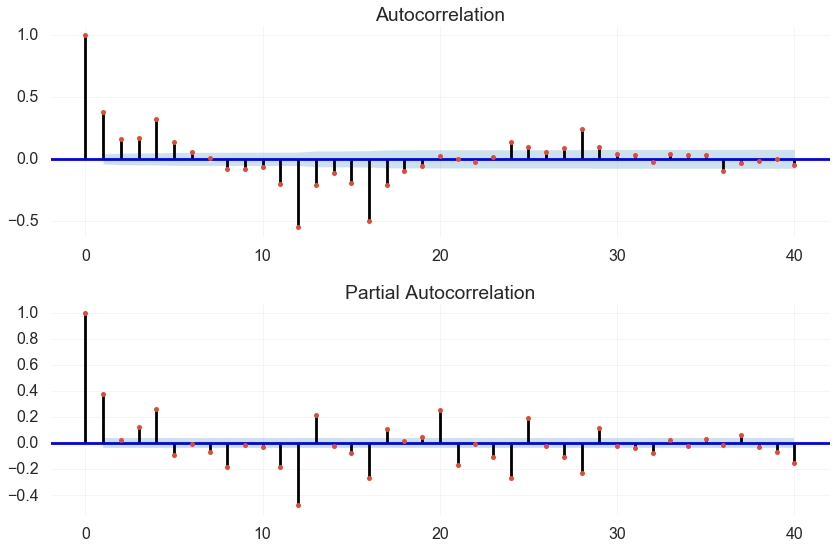

In [146]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal_difference_neiger.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal_difference_neiger.iloc[13:], lags=40, ax=ax2)

Now we can build the model. We use a SARIMAX model that will accounnt for seasonality.

In [147]:
model_neiger = sm.tsa.statespace.SARIMAX(rolmean_neiger_train, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
results_neiger = model_neiger.fit()
print(results_neiger.summary())

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:229: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             neiger   No. Observations:                 2300
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                     nan
Date:                            Sun, 29 Jan 2017   AIC                                nan
Time:                                    17:06:10   BIC                                nan
Sample:                                         0   HQIC                               nan
                                           - 2300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3661   2.57e-09   1.42e+08      0.000       0.366       0.366
ma.S.L12      -0.6187   1.52e-09  -

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Prediction from the model for the word "neiger"

Now that the model is built from the serie we can use it to see how it predict one year and compare that to the actual serie.

We can make in-sample forecast which means prediction for a period from which we used the data for the training model and out-sample forecast which means prediciton for a period from which we don't used the data for training the model. The out-sample forecast can be compared to the 3 years that we left out of the time serie.

Here is an in-sample prediction for 12 month for the word neige starting in september 1936.

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


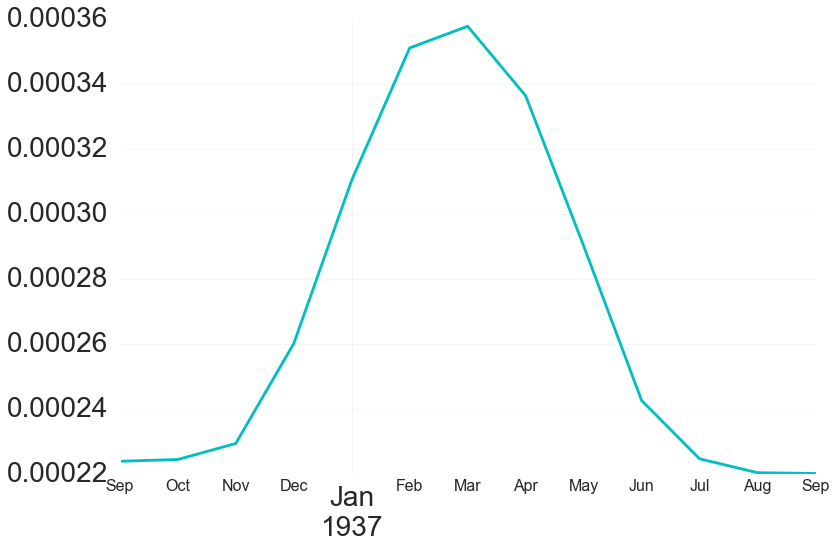

In [148]:
prediction_neiger = results_neiger.predict(start = 1600, end= 1612, dynamic= True)  
prediction_neiger.plot(figsize=(12, 8), c='c')

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)


And here is the comparaison with the original serie. We show the prediction of the model for a period of one year.

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


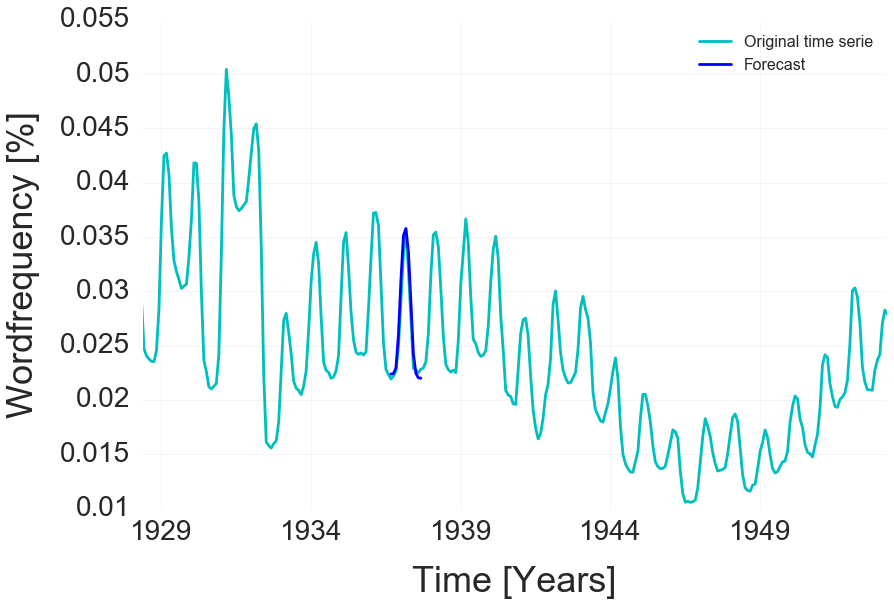

In [149]:
ax = rolmean_neiger_train[1500:1800].plot(style='c')
ax = prediction_neiger.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"])

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

We can do the same for any other period of one year. 

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


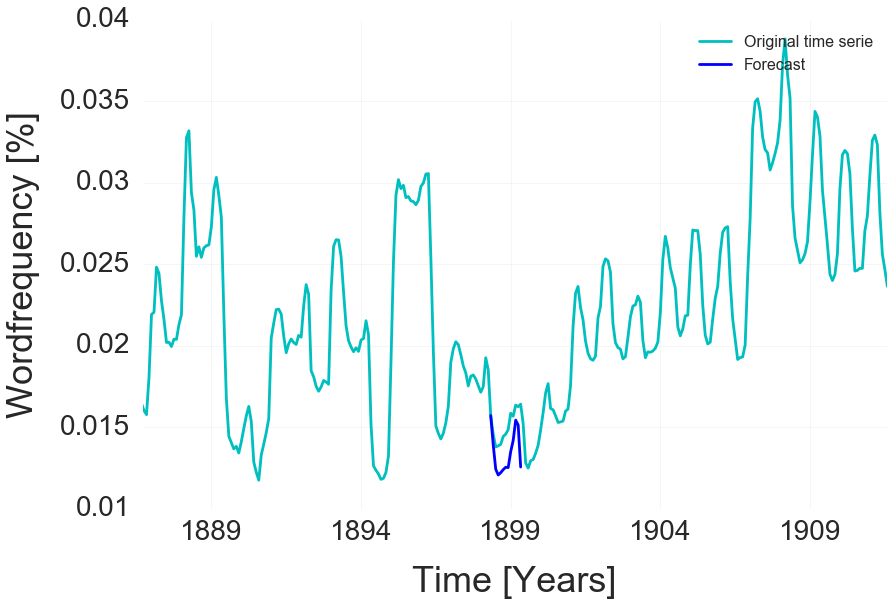

In [150]:
prediction_neiger = results_neiger.predict(start = 1140, end= 1152, dynamic= True)  

ax = rolmean_neiger[1000:1300].plot(style='c')
ax = prediction_neiger.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"])

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)


We can see that the model can approximate the original serie relatively well.


We can trying to predict longer period. Let's try 3 years. This is still in-sample forecast. This is just the duration that change.

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


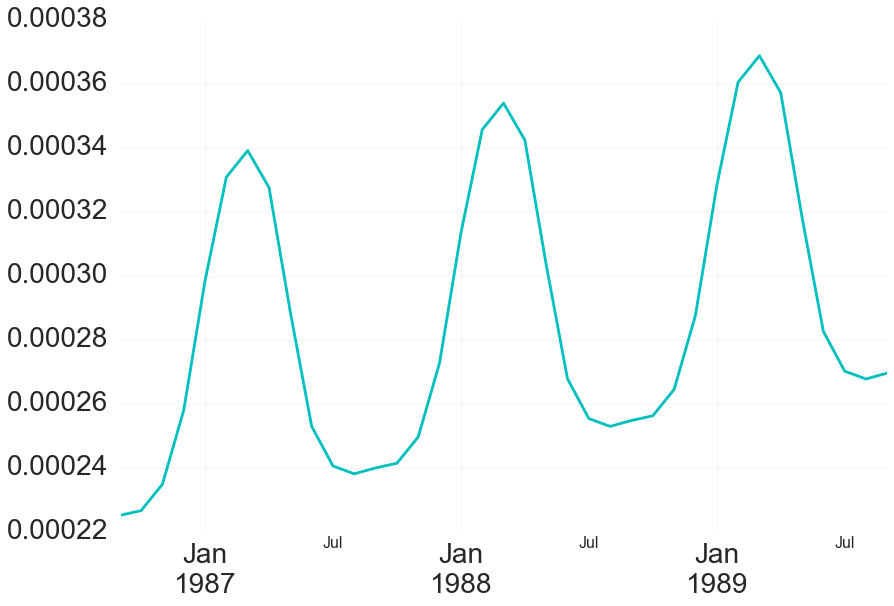

In [151]:
prediction_neiger_3 = results_neiger.predict(start = 2200, end= 2236, dynamic= True)  
prediction_neiger_3.plot( style='c')

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


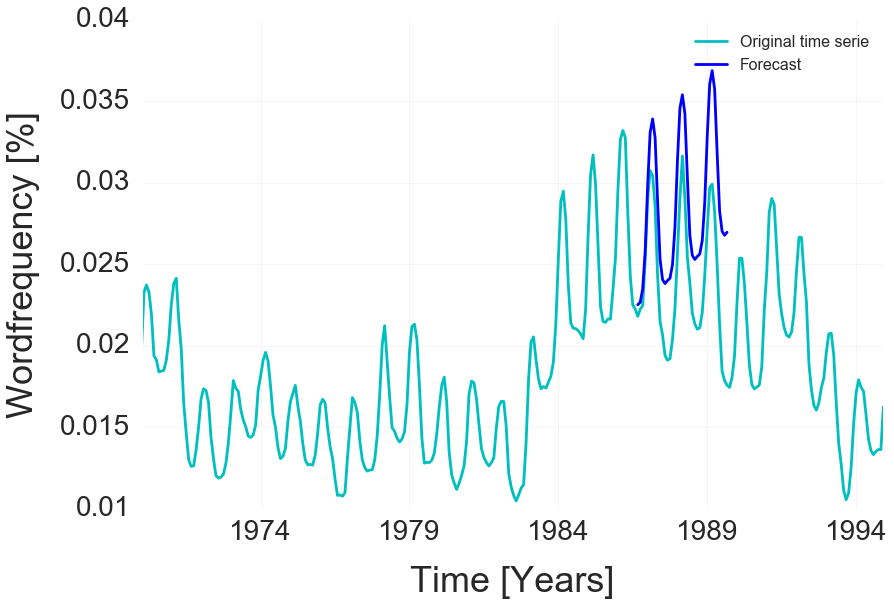

In [152]:
ax = rolmean_neiger_train[2000:].plot(style='c')
ax = prediction_neiger_3.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"])

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

We can see that the model has a trend with the seasonality and the longer is the time period the worse is the fit.

Now we can try to make out-sample forecast for the future. We will try to predict the next year of word frequency "neiger" for the beginning.



//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


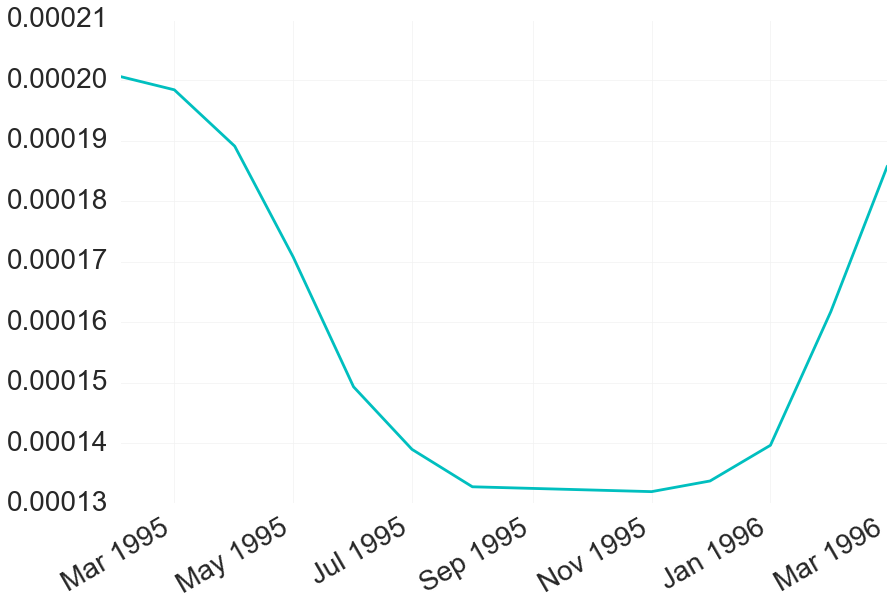

In [153]:
prediction_neiger_out = results_neiger.predict(start = 2301, end= 2312, dynamic= True)  
prediction_neiger_out.index = rolmean_neiger[2301:2313].index

prediction_neiger_out.plot(style='c')

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)


Here is the one year prediction. Let's compare it with the corresponding original serie

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


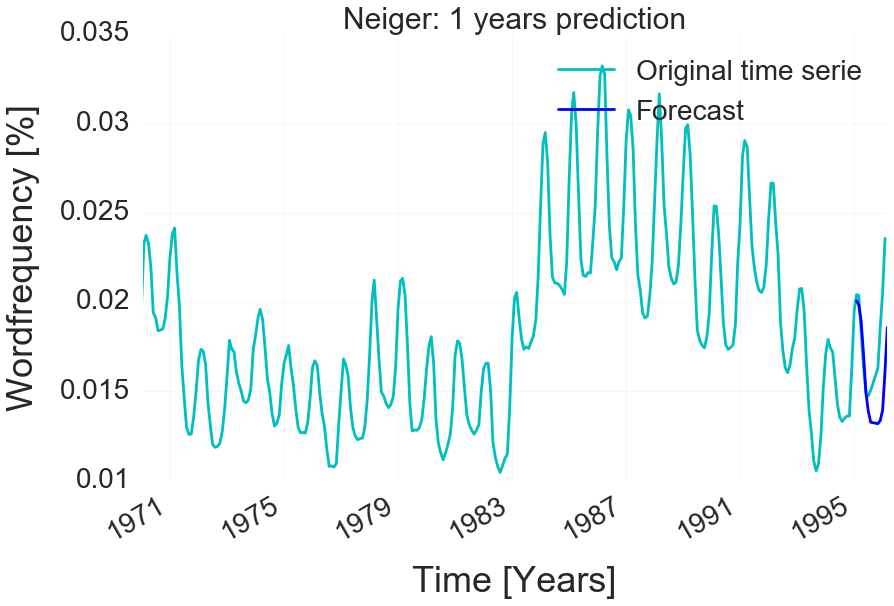

In [155]:
ax = rolmean_neiger[2000:2312].plot(style='c')
ax = prediction_neiger_out.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_title("Neiger: 1 years prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)



plt.savefig('Plots/Neiger_one_year_forecast.png')



It seems to be a relatively good approximation of the origninal time serie. Even though the amplitude is not perfectly correct, the model has correctly integrated the seasonality.

Now let's see for 2 year and 3 years in the futur.

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


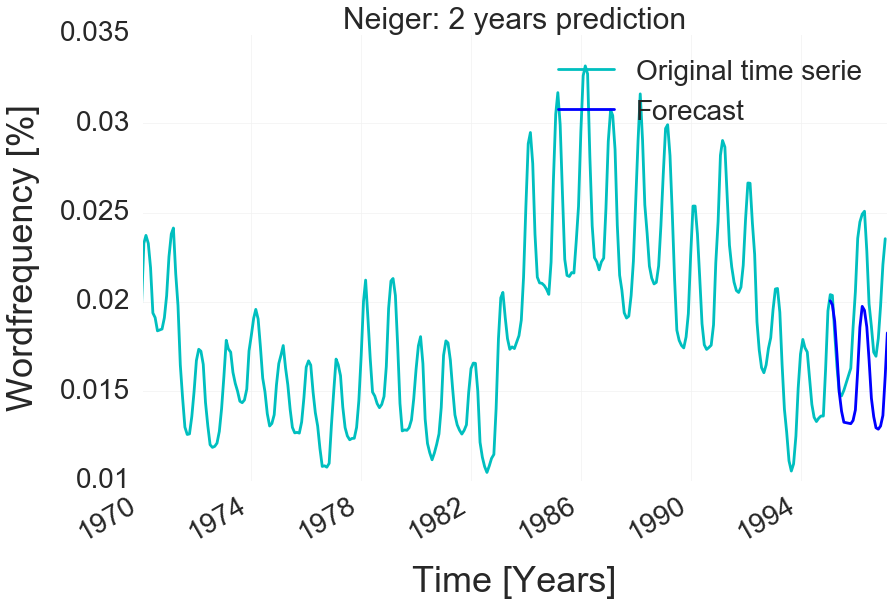

In [156]:
prediction_neiger_out_2 = results_neiger.predict(start = 2301, end= 2324, dynamic= True)

prediction_neiger_out_2.index = rolmean_neiger[2301:2325].index

ax = rolmean_neiger[2000:2324].plot(style='c')
ax = prediction_neiger_out_2.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_title("Neiger: 2 years prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

plt.savefig('Plots/Neiger_two_year_forecast.png')

Now 3 years

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


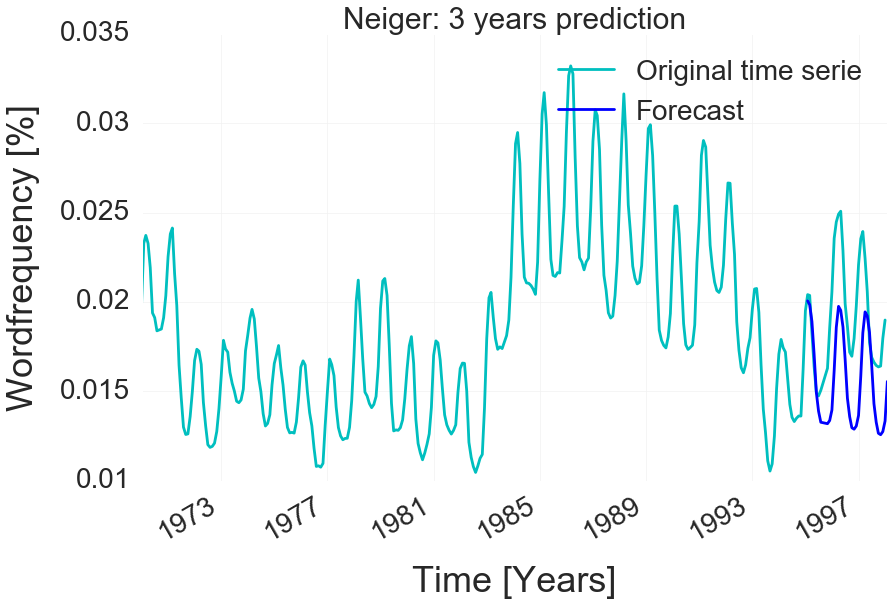

In [157]:
prediction_neiger_out_3 = results_neiger.predict(start = 2301, end= 2335, dynamic= True)

prediction_neiger_out_3.index = rolmean_neiger[2301:2336].index

ax = rolmean_neiger[2000:2335].plot(style='c')
ax = prediction_neiger_out_3.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_title("Neiger: 3 years prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)



plt.savefig('Plots/Neiger_three_year_forecast.png')

We can see that the model has correctly integrated the seasonal component of the time serie. However it seems to have trouble to follow the exact same local trend. This is coherent in the sense that this local trend can be considered to be random as in a random walk. The model can forecast the futur word frequency base on a seasonality and a trend that it extrapolate from the fitting but it cannot predict local random trend.

At long term the forecast is simply a repetition of this seasonality toward a trend it extrapolated from the last data of the model.

To convince yourself look a the 10 years forecast.

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


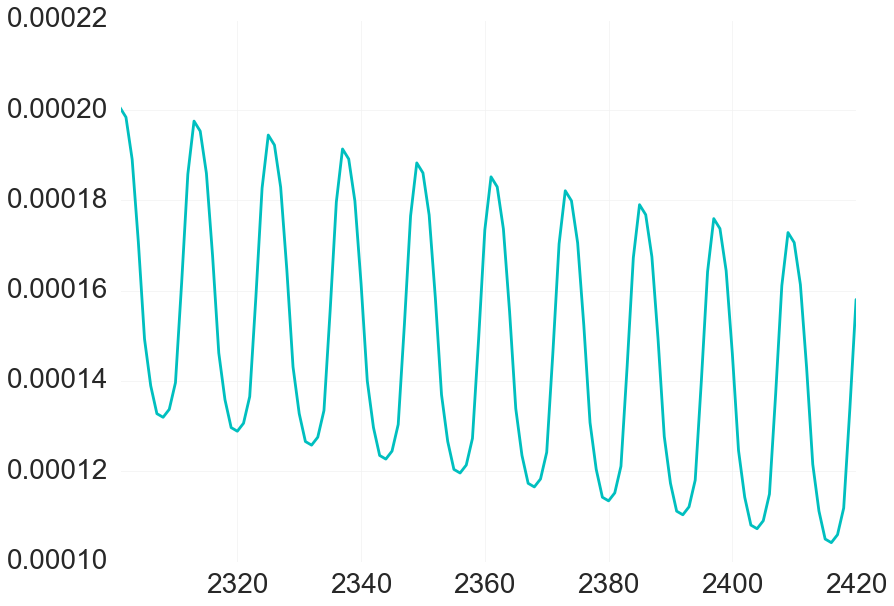

In [137]:
prediction_neiger_out = results_neiger.predict(start = 2301, end= 2420, dynamic= True)  
prediction_neiger_out.plot(style='c')

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)



We can clearly see that the model is repeating itself. But on a short term horizon the prediction is convincing enough. Indeed the forecast could be seen as the real continuation of the time serie on a short basis.

Of course in the long term the model forecast are more and more improbable.

# Prediction for the word "noële"

Now we can make the same process all over again for the word second seasonal word we choosed.



We can perform the same model fitting, prediction and forecasting for the word "noële" and see how it compare.

In [158]:
model_noele = sm.tsa.statespace.SARIMAX(rolmean_noele_train, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
results_noele = model_noele.fit()
print(results_noele.summary())

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:229: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              noële   No. Observations:                 2300
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                     nan
Date:                            Sun, 29 Jan 2017   AIC                                nan
Time:                                    17:07:35   BIC                                nan
Sample:                                         0   HQIC                               nan
                                           - 2300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5793   7.43e-07   7.79e+05      0.000       0.579       0.579
ma.S.L12      -0.3890      5e-07  -

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


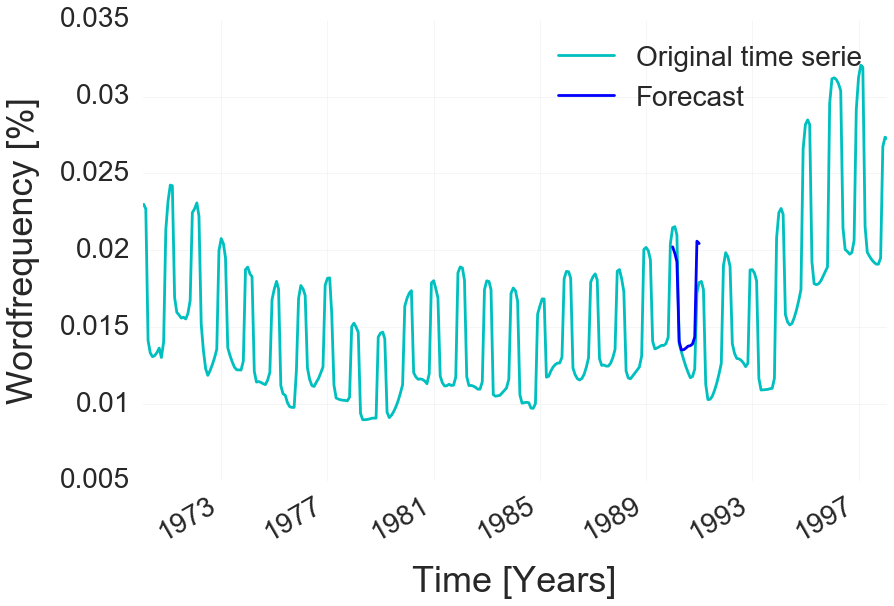

In [160]:
prediction_noele = results_noele.predict(start = 2240, end= 2252, dynamic= True)  
ax = rolmean_noele[2000:].plot(style='c')
ax = prediction_noele.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)





Here for a longer period.

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


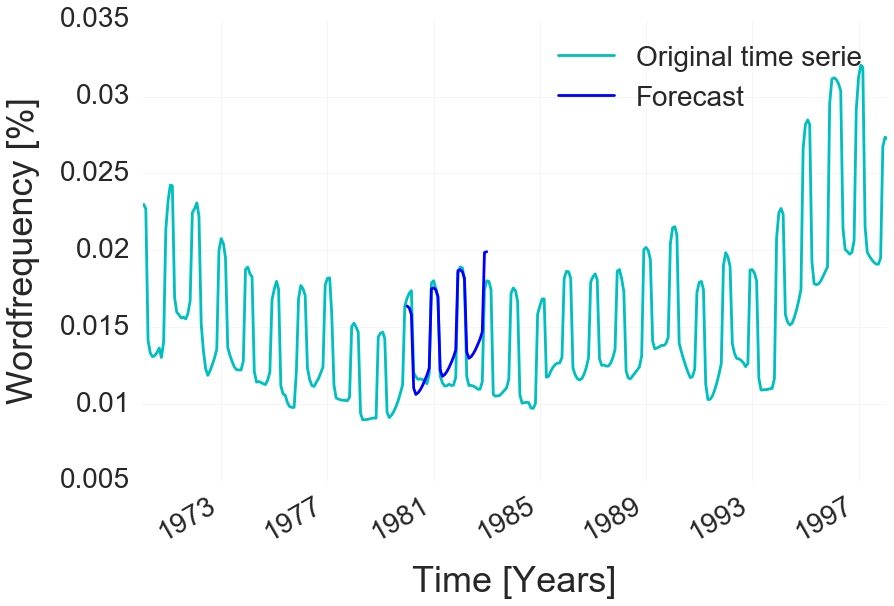

In [161]:
prediction_noele = results_noele.predict(start = 2120, end= 2156, dynamic= True)  
ax = rolmean_noele[2000:].plot(style='c')
ax = prediction_noele.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

We can see that the model can approximate the real time serie relatively well even for longer period. This could be due to the fact that the seasonality and the amplitude of seasonality is very regular for the word "noele".

Now let's see the out-sample forecast for 1, 2 and 3 years horizons.

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


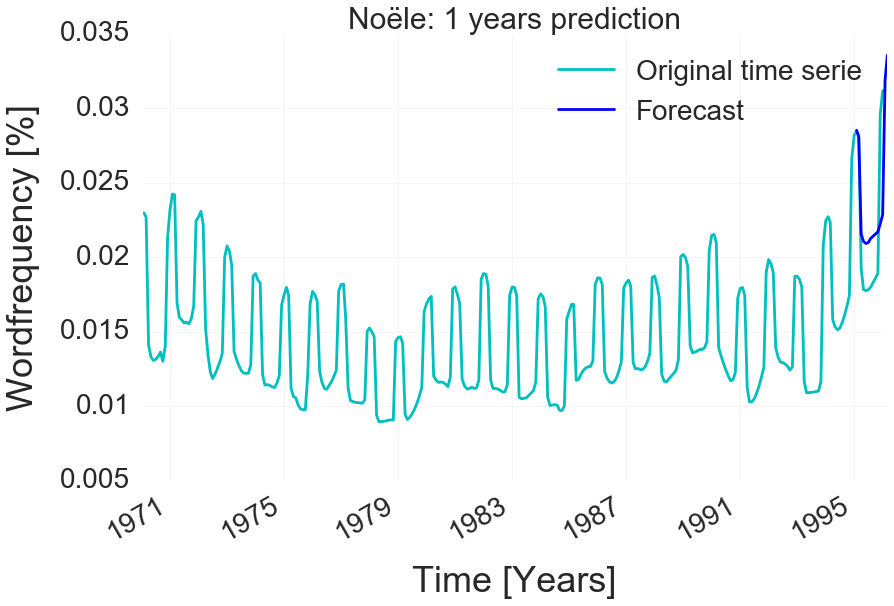

In [162]:
prediction_noele_out = results_noele.predict(start = 2301, end= 2312, dynamic= True)

prediction_noele_out.index = rolmean_noele[2301:2313].index

ax = rolmean_noele[2000:2312].plot(style='c')
ax = prediction_noele_out.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_title("Noële: 1 years prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

plt.savefig('Plots/Noele_one_year_forecast.png')

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


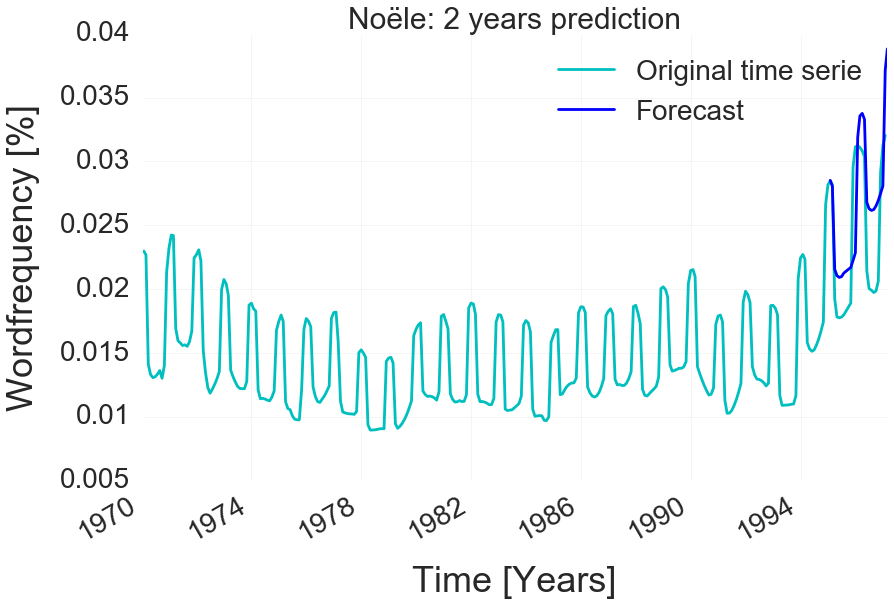

In [163]:
prediction_noele_out_2 = results_noele.predict(start = 2301, end= 2324, dynamic= True)

prediction_noele_out_2.index = rolmean_noele[2301:2325].index

ax = rolmean_noele[2000:2324].plot(style='c')
ax = prediction_noele_out_2.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_title("Noële: 2 years prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

plt.savefig('Plots/Noele_two_year_forecast.png')

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:502: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


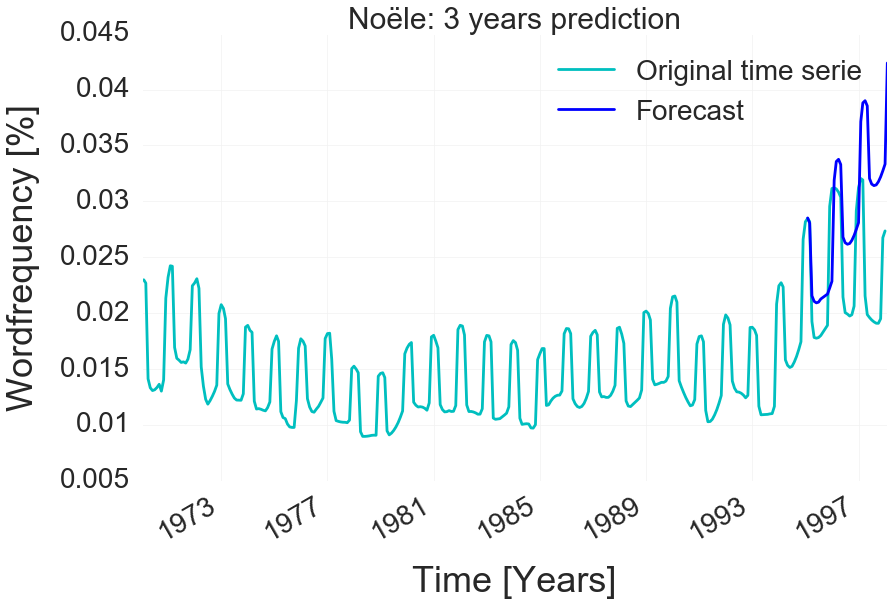

In [164]:
prediction_noele_out_3 = results_noele.predict(start = 2301, end= 2335, dynamic= True)

prediction_noele_out_3.index = rolmean_noele[2301:2336].index

ax = rolmean_noele[2000:2335].plot(style='c')
ax = prediction_noele_out_3.plot(ax=ax, style='b', label='Dynamic Prediction');

ax.set_title("Noële: 3 years prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","Forecast"], fontsize=28)

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

plt.savefig('Plots/Noele_three_year_forecast.png')

Again the model as correctly integrated the seasonality and the trend is in the right direction while the amplitude is not good. 